# MC Dropout
https://github.com/yaringal/DropoutUncertaintyExps/blob/master/net/net.py

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('GPU device not found. Using CPU')
else:
    print('Found GPU: {}'.format(tf.test.gpu_device_name()))

Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


In [15]:
# commons package
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
importlib.reload(cm)

<module 'commons' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\commons.py'>

# Configuration and Parameters

In [3]:
# GloVe Configuration

# Directory containing the GloVe files.
GLOVE_DIR = "D:/google drive/haw/master/mastertheisis/hauptprojekt"

# Embedding dimension
EMBEDDING_DIM = 50

In [16]:
setup = cm.setup(glove_dir=GLOVE_DIR, embedding_dim=EMBEDDING_DIM)
(x_train, x_train_padded, y_train) = setup["train"]
(x_test, x_test_padded, y_test) = setup["test"]
word_index = setup["word_index"]

Found 400000 word vectors.
17361/88587 unknown words


In [24]:
# MC Dropout parameters

# model save file
model_save_file = "./models/mc_dropout.h5"

# number of data points
N = x_train.shape[0]

# hidden layers where each element denotes the number of neurons
n_hidden = [64, 64, 32]

# descriptive model name
model_name = "__mc_dropout__%s" % "_".join(map(str, n_hidden))

# model save file
model_save_file = "./models/%s.h5" % model_name

# history save file
history_save_file = "./history/%s.csv" % model_name

# batch size for training
batch_size = 128

# training epochs 
epochs = 1

# prior lenght scale
lengthscale = 1e-2

# dropout rate for all dropout layers in the network, 1. means drop all
dropout = 0.5

# model precision used for regularization
tau = 1.0

# regularization
reg = lengthscale**2 * (1 - dropout) / (2. * N * tau)

# MCMC Samples
T = 500

# History

In [18]:
(history_df, last_epoch) = cm.load_history_from_file(history_save_file=history_save_file)

No saved history file


# Model

In [25]:
def create_model():
    inputs = tfk.Input(shape=(x_train_padded.shape[1],), dtype='int32')

    # embedding layer
    inter = setup["embedding_layer"](inputs)

    for i in range(len(n_hidden)):
        inter = tfkl.Dropout(dropout)(inter, training=True)
        inter = tfkl.Dense(n_hidden[i], activation='relu', kernel_regularizer=tfk.regularizers.l2(reg))(inter)

    inter = tfkl.Dropout(dropout)(inter, training=True)
    inter = tfkl.Flatten()(inter)
    outputs = tfkl.Dense(1, kernel_regularizer=tfk.regularizers.l2(reg), activation="sigmoid")(inter)
    model = tfk.Model(inputs, outputs, name=model_name)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=cm.metrics)
    return model

try:
    model = tfk.models.load_model(model_save_file)
    print("using saved model")
except:
    model = create_model()
    print("model has not been trained")

model.summary()

model has not been trained
Model: "__mc_dropout__64_64_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2697)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 2697, 50)          4429400   
_________________________________________________________________
dropout_13 (Dropout)         (None, 2697, 50)          0         
_________________________________________________________________
dense_11 (Dense)             (None, 2697, 64)          3264      
_________________________________________________________________
dropout_14 (Dropout)         (None, 2697, 64)          0         
_________________________________________________________________
dense_12 (Dense)             (None, 2697, 64)          4160      
_________________________________________________________________
dropout_15 (Dropo

In [26]:
model.fit(x_train_padded, 
          y_train, 
          validation_split=0.05,
          epochs=epochs,
          initial_epoch=last_epoch,
          batch_size=batch_size, 
          callbacks=cm.get_keras_callbacks(model_save_file=model_save_file, history_save_file=history_save_file))

W0620 23:21:36.202035  1124 deprecation.py:323] From C:\Users\Tom\Anaconda3\envs\mltf2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 23750 samples, validate on 1250 samples


InternalError:  Blas GEMM launch failed : a.shape=(345216, 50), b.shape=(50, 64), m=345216, n=64, k=50
	 [[node dense_11/Tensordot/MatMul (defined at <ipython-input-26-73140b499975>:7) ]] [Op:__inference_keras_scratch_graph_4266]

Function call stack:
keras_scratch_graph


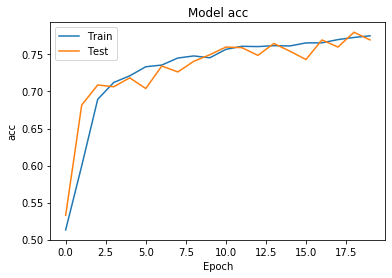

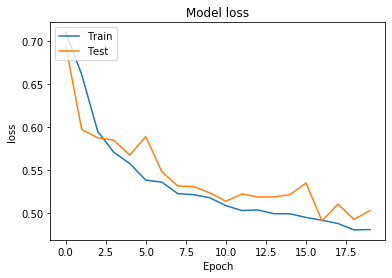

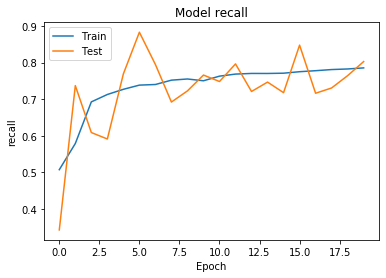

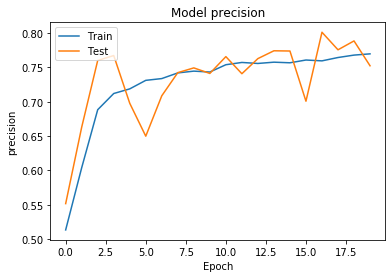

In [27]:
for metric in ["acc", "loss", "recall", "precision"]:
    cm.plot_metric(metric, history_df)

Training data predictions: mean of 0.5 and std of 0.5

<START> please give this one a miss br br kristy swanson <UNK> <START> rest of <START> cast rendered terrible performances <START> show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out <UNK> his performance was quite lacklustre so all you madison fans give this a miss
Expected: 0, Predicted mean: 0.467776, rmse: 0.490100, std: 0.146233


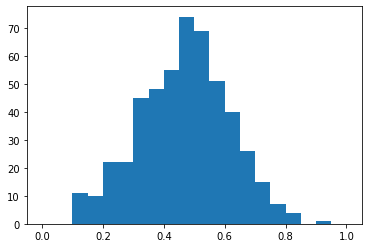




<START> this film requires a lot of patience because it focuses on mood <UNK> character development <START> plot is very simple <UNK> many of <START> scenes take place on <START> same set in frances austen's <START> sandy dennis character apartment but <START> film builds to a disturbing climax br br <START> characters create an atmosphere rife with sexual tension <UNK> psychological trickery it's very interesting that robert altman directed this considering <START> style <UNK> structure of his other films still <START> trademark altman audio style is evident here <UNK> there i think what really makes this film work is <START> brilliant performance by sandy dennis it's definitely one of her darker characters but she plays it so perfectly <UNK> convincingly that it's scary michael burns does a good job as <START> mute young man regular altman player michael murphy has a small part <START> solemn moody set fits <START> content of <START> story very well in short this movie is a powerf

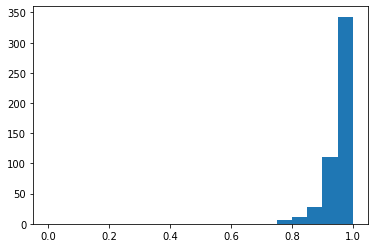




<START> many animation buffs consider wladyslaw starewicz <START> great forgotten genius of one special branch of <START> art puppet animation which he invented almost single handedly <UNK> as it happened almost accidentally as a young man starewicz was more interested in entomology than <START> cinema but his unsuccessful attempt to film two stag beetles fighting led to an unexpected breakthrough in film making when he realized he could simulate movement by manipulating beetle carcasses <UNK> photographing them one frame at a time this discovery led to <START> production of amazingly elaborate classic short <START> cameraman's revenge which he made in russia in 1912 at a time when motion picture animation of all sorts was in its infancy br br <START> political tumult of <START> russian revolution caused starewicz to move to paris where one of his first productions coincidentally was a dark political satire variously known as frogland or <START> frogs who wanted a king a strain of b

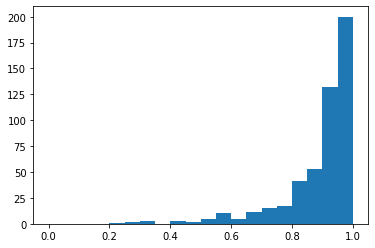




<START> i generally love this type of movie however this time i found myself wanting to kick <START> screen since i can't do that i will just complain about it this was absolutely idiotic <START> things that happen with <START> dead kids are very cool but <START> alive people are absolute idiots i am a grown man pretty big <UNK> i can defend myself well however i would not do half <START> stuff <START> little girl does in this movie also <START> mother in this movie is reckless with her children to <START> point of neglect i wish i wasn't so angry about her <UNK> her actions because i would have otherwise enjoyed <START> flick what a number she was take my advise <UNK> fast forward through everything you see her do until <START> end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are impossibly involved with <START> actions on <START> screen so then why <START> hell can't we have night visi

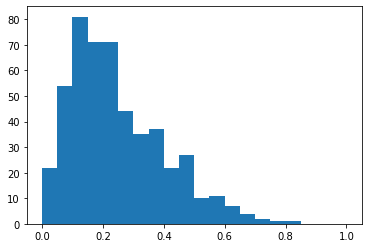




<START> like some other people wrote i'm a die hard mario fan <UNK> i loved this game br br this game starts slightly boring but trust me it's worth it as soon as you start your hooked <START> levels are fun <UNK> exiting they will hook you 'till your mind turns to mush i'm not kidding this game is also orchestrated <UNK> is beautifully done br br to keep this spoiler free i have to keep my mouth shut about details but please try this game it'll be worth it br br story 9 9 action 10 1 it's that good hardness 10 attention grabber 10 average 10
Expected: 1, Predicted mean: 0.394148, rmse: 0.624299, std: 0.150640


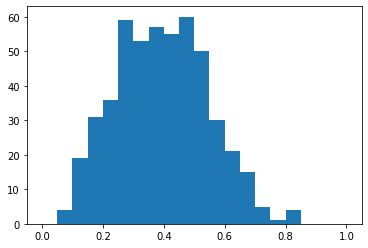




<START> i'm absolutely disgusted this movie isn't being sold all who love this movie should email disney <UNK> increase <START> demand for it they'd eventually have to sell it then i'd buy copies for everybody i know everything <UNK> everybody in this movie did a good job <UNK> i haven't figured out why disney hasn't put this movie on dvd or on vhs in rental stores at least i haven't seen any copies this is a wicked good movie <UNK> should be seen by all <START> kids in <START> new generation don't get to see it <UNK> i think they should it should at least be put back on <START> channel this movie doesn't deserve a cheap download it deserves <START> real thing i'm them now this movie will be on dvd
Expected: 1, Predicted mean: 0.224959, rmse: 0.786221, std: 0.132114


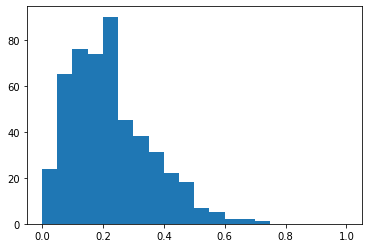




<START> originally supposed to be just a part of a huge epic <START> year 1905 depicting <START> revolution of 1905 potemkin is <START> story of <START> mutiny of <START> crew of <START> potemkin in odessa harbor <START> film opens with <START> crew protesting meat <UNK> <START> captain ordering <START> execution of <START> an uprising takes place during which <START> revolutionary leader is killed this crewman is taken to <START> shore to lie in state when <START> townspeople gather on a huge flight of steps overlooking <START> harbor czarist troops appear <UNK> march down <START> steps breaking up <START> crowd a naval squadron is sent to retake <START> potemkin but at <START> moment when <START> ships come into range their crews allow <START> to pass through eisenstein's non historically accurate ending is open ended thus indicating that this was <START> seed of <START> later bolshevik revolution that would bloom in russia <START> film is broken into five parts men <UNK> maggots 

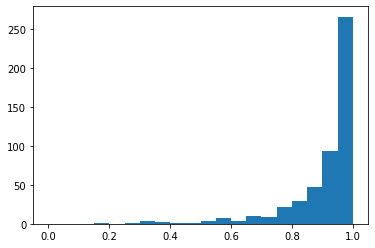




<START> <START> emperor's richard haydn dog is betrothed to johanna's joan fontaine dog however when virgil bing crosby arrives in town to sell a record player to <START> emperor his dog is attacked by johanna's dog after a revenge attack where virgil is banished from town a psychoanalyst insists that johanna's dog must confront dog so that she can overcome her doggy fears this is arranged <UNK> <START> dogs fall in love so do virgil <UNK> johanna <START> rest of <START> film passes by with romance <UNK> at <START> end johanna's dog gives birth but who is <START> father br br <START> dog story is <START> very weak vehicle that is used to try <UNK> create a story between humans its a terrible storyline there are 3 main musical pieces all of which are rubbish bad songs <UNK> dreadful choreography its just an extremely boring film bing has too many words in each sentence <UNK> delivers them in an almost irritating manner its not funny ever but its meant to be bing <UNK> joan have done 

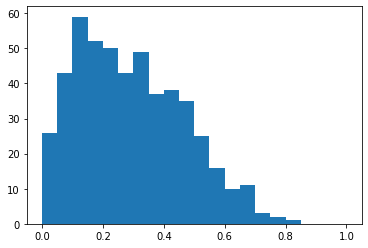




<START> hollywood had a long love affair with bogus arabian nights tales but few of these products have stood <START> test of time <START> most memorable were <START> jon hall maria montez films which have long since become camp this one is filled with dubbed songs anachronistic slang <UNK> slapstick it's a truly crop of corn <UNK> pretty near intolerable today it was nominated for its imaginative special effects which are almost unnoticeable in this day <UNK> age consisting mainly of trick photography <START> only outstanding positive feature which survives is its beautiful color <UNK> clarity sad to say of <START> many films made in this genre few of them come up to alexander korda's original thief of baghdad almost any other arabian nights film is superior to this one though it's a loser
Expected: 0, Predicted mean: 0.654092, rmse: 0.678896, std: 0.181835


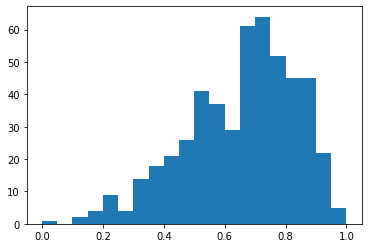




<START> this film is where <START> batman franchise ought to have stopped though i will concede that <START> ideas behind batman forever were excellent <UNK> could have been easily realised by a competent director as it turned out this was not to be <START> case br br apparently warner brothers executives were disappointed with how dark this second batman film from tim burton turned out apart from <START> idiocy of expecting anything else from burton <UNK> <START> conservative cowardice of their subsequent decision to turn <START> franchise into an homage to <START> sixties tv series i fail to understand how batman returns can be considered at all disappointing br br true it is not quite <START> equal of <START> first film though it repairs all <START> minor deficiencies of style found in batman a weaker script that splits <START> antagonism between not just two but three characters invites unflattering comparisons to <START> masterful pairing of keaton <UNK> jack nicholson as <STAR

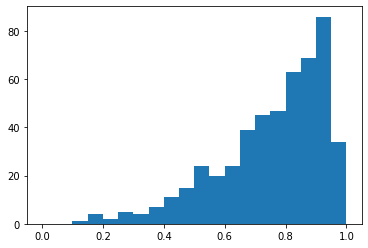




<START> inspired by hitchcock's strangers on a train concept of two men swapping murders in exchange for getting rid of <START> two people messing up their lives throw momma from <START> train is an original <UNK> very inventive comedy take on <START> idea it's a credit to danny devito that he both wrote <UNK> starred in this minor comedy gem br br anne ramsey is <START> mother who inspires <START> film's title <UNK> it's understandable why she gets under <START> skin of danny devito with her sharp tongue <UNK> relentlessly putting him down for any minor infraction billy crystal is <START> writer who's wife has stolen his book idea <UNK> is now being lionized as a great new author even appearing on <START> oprah show to in adulation he should be enjoying thus devito gets <START> idea of swapping murders to rid themselves of these nuisance factors br br of course everything <UNK> anything can happen when writer carl reiner lets his imagination roam with unending ideas for how <START>

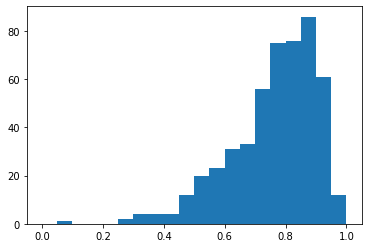




<START> when i first saw this movie in <START> theater i was so angry it completely blew in my opinion i didn't see it for a decade then decided what <START> hell let's see i'm watching all hellraiser movies now to see where it went wrong my guess is it was with sequel 5 that was <START> first to implement <START> whole i am in a dream omg i see weird stuff oh noes what is happening oh its a dream oh its not a dream oh wait i see something spooky oh never mind sucky storyline those sequels don't even require <START> box to be opened or stick to <START> rules from <START> first 4 movies that if you saw pinhead you are pretty much screwed <UNK> dead <START> first 3 sticked to this storyline which made it so scary in <START> first place nothing fantasy nothing weird <START> box got opened boom they came was <START> only one that could bargain her way out of it first because of uncle frank then because she had information about <START> this movie at least attempts to stick to all that e

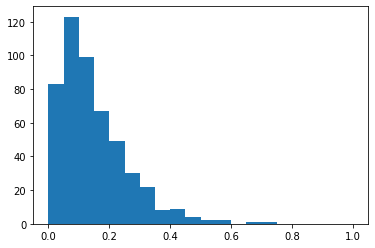




<START> oh dear oh dear it really gets on my nerves when a low budget pointless horror affair tries to look interesting in <START> credits by having a bunch of good names pop up in <START> cast only to involve each one in <START> smallest most pointless possible roles in this film we have richard lynch in one scene a momentary appearance from martin kove a brief spot for vernon welles slightly more time on screen for john philip law <UNK> a little time for karen black this bunch of random cameos does not really add up to much though richard lynch <UNK> karen black do raise some of <START> few smiles of this film with their appearances <UNK> its quite painful really as none of <START> main cast are much good at all i couldn't help but think that if more scenes were filmed with any of <START> b movie veterans above <START> film would be a whole lot better but as it is there are just a few tantalising glimpses of good entertainment without <START> film ever actually attaining much ente

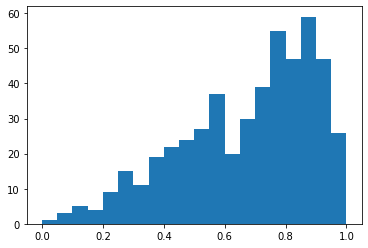




<START> i started watching this because i thought it was a really shitty porno as i kept watching <START> only thrill i got from this movie was finding out what <START> name of it was so i could look it up <UNK> rip on it i just finished it <UNK> have considered ending my life knowing that someone actually made this movie br br for <START> people who commented on this movie as having a good script <UNK> great acting my words of wisdom for you are that you probably have no friends because you were in <START> movie you are probably wishing you had all that time back of your life that you wasted on making this movie br br there is no way that this is a serious movie there was an old guy that gets stabbed <UNK> it doesn't even hurt him at all <UNK> when everyone else gets stabbed they drop dead br br it was probably important that these people killed random people <UNK> ate them <UNK> also hung out with an 80 year old man that wanted to put <START> parts into his body br br my favorite 

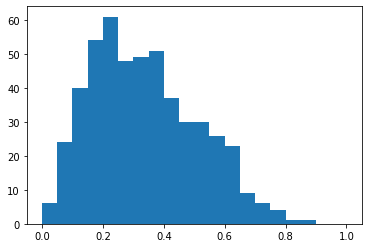




<START> a touching documentary that puts a human face on <START> tragedy of 9 11 by showing how one small community to honor two high school friends lost on that day <START> film interweaves <START> lives of chris <UNK> tom through interviews with family <UNK> friends <UNK> snippets of old photos through their reminiscences we glimpse two lives tragically cut short <START> film also documents how through a series of coincidences an inspirational memorial garden was brought forth through <START> efforts of many people both known <UNK> unknown to <START> two victims through <START> laughter <UNK> <START> tears <UNK> <START> sweat we see <START> power of hope <UNK> honor <UNK> love this films evokes many different emotions but <START> final feeling is one of admiration of <START> human spirit by tragedy
Expected: 1, Predicted mean: 0.894522, rmse: 0.125530, std: 0.068060


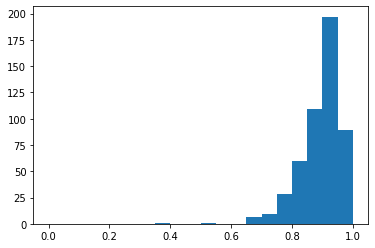




<START> let me first start out by saying 1 out of 10 is too good for this movie it's unfortunate that imdb doesn't have tenths of a star i watched this abortion of a movie in <START> middle of <START> night due to insomnia <UNK> it was absolute garbage <START> plot was horrible <START> acting was horrible <START> movie was utterly boring looked like <START> shadow with alec baldwin <START> shadow is infinitely better than this as well <START> character eve was so undeveloped <UNK> 2 dimensional she didn't even grab my attention i didn't even know her name was eve don was interesting when he kept his mouth shut <START> twist if you can call it that was laughable <UNK> pathetic when it came <START> movie had done such a horrid job of building suspense or attachment to any character that i simply thought who gives a s <START> only thing that made me even lift an eyebrow about this movie was <START> fact <START> med teacher was dyson in terminator 2 also a movie that was light years ahe

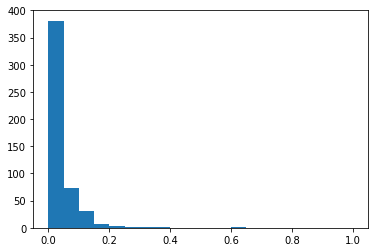




<START> from 1996 first i watched this movie i feel never reach <START> end of my satisfaction i feel that i want to watch more <UNK> more until now my god i don't believe it was ten years ago <UNK> i can believe that i almost remember every word of <START> dialogues i love this movie <UNK> i love this novel absolutely perfection i love willem defoe he has a strange voice to spell <START> words black night <UNK> i always say it for many times never being bored i love <START> music of it's so much made me come into another world deep in my heart anyone can feel what i feel <UNK> anyone could make <START> movie like this i don't believe so thanks thanks
Expected: 1, Predicted mean: 0.786513, rmse: 0.236848, std: 0.102568


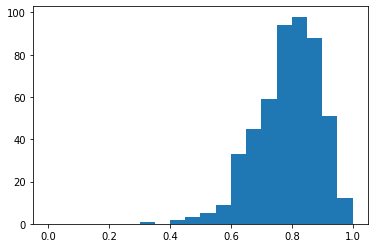




<START> ed kel mitchell is a teenager who lives for his job at good burger a small but friendly neighborhood hamburger stand while his buddy dexter thompson also works there but lack ed's single minded devotion to his job he's there because he accidentally destroyed <START> car of his teacher mr wheat sinbad <UNK> has to raise money to pay <START> damages when mondo burger a mammoth fast foot chain opens across <START> street it looks like good burger is history until ed formulates a secret sauce that brings hundreds of new customers to their door however <START> monomaniacal manager of mondo burger kurt jan is determined to get his hands on <START> sauce <UNK> put good burger out of business meanwhile ed <UNK> dexter must rescue otis abe vigoda <START> world's oldest fast food employee from <START> demented hills asylum <UNK> ed might just find love with monique jackson if he could take his mind off <START> burgers long enough to pay attention to her good burger is a comedy directe

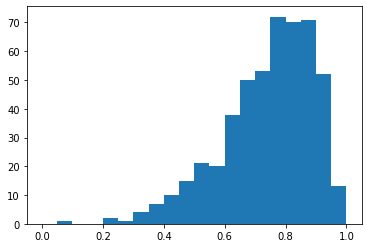




<START> i was really geared up to watch when two of best movie critics tagged this movie as a 'laugh but <START> movie turned out be disappointing br br you will be advised to watch this movie keeping your brains at home but you simply can't ignore <START> flaws <UNK> <START> shortcomings br br 1 <START> missile scene was total stupidity br br 2 katrina kaif <UNK> govinda pair looked awful he's 49 <UNK> she's just 24 more than double of her age 3 salman's comedy is less of acting <UNK> more of overacting br br 4 songs are good but interrupts <START> pace of <START> movie br br 5 some scenes were deliberately attempted by <START> movie makers to be funny <UNK> 6 poor <UNK> flawed story br br however there are few pluses 1 govinda great individual performance br br 2 some scenes are actually quite funny br br 3 kaif looks <UNK> acting keeps on improving with every film br br 4 rajpal yadav's don sequences though under utilized but hilarious br br so 4 good points 6 bad ones this one g

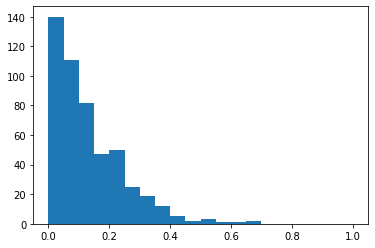




<START> right so you have a dam tons of water that seems to flow really really slowly <UNK> a small town that happens to be right underneath <START> path of destruction throw in a profiteering glutton an apparently mentally unstable <UNK> disgruntled architect <UNK> his son <UNK> then to spice things up you add a weak plot <UNK> bad acting all in all when you have a look at this film from a paying customers point of view i would feel extremely peeved off if this was a pay per view film if you want a laugh then you really need to watch this film
Expected: 0, Predicted mean: 0.203350, rmse: 0.235282, std: 0.118349


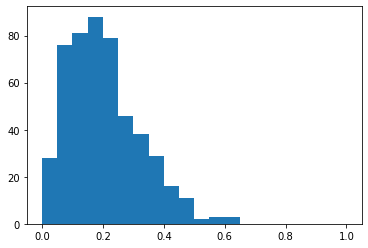




<START> this film was one that i have waited to see for some time i was glad to find it has been everything anticipated <START> writing of this film has been so finely crafted <UNK> researched far beyond what is seen by <START> audience i found it amusing that so many people watching will not read between some very important lines but indeed if not <START> movie will make sense in a different way <UNK> is very brilliant <START> film has many stories <UNK> characters woven together around this one character kilo a man whom has rose from <START> streets amidst many woes <UNK> become a very powerful criminal after spending some time in prison kilo finds a loophole in <START> justice system <UNK> through a disturbing turn of events is released only to find everything is not at all what it seems kilo finds himself going up against <START> higher realm of society <UNK> political royalty in order to make clear how important a man's word is <UNK> stands for a war begins as <START> street is

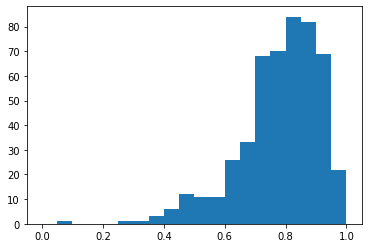




<START> this is one of my favourite disney films it has everything you could hope for in a disney animation cute animals great songs a nasty villain <UNK> lots of adventure <START> story begins in paris where duchess <UNK> her three kittens live with their mistress in a mansion life is perfect for them until <START> fiendish butler edgar discovers that she plans to leave her entire fortune to <START> cats he realises that if he even stands a chance of claiming <START> fortune <START> cats will be out of <START> way an excellent often forgotten masterpiece from <START> 1970's a time when <START> disney studio made few animations which features songs such as <START> title number <START> aristocats as well as wants to be a cat this will enchant viewers young <UNK> old with its enduring
Expected: 1, Predicted mean: 0.874491, rmse: 0.148810, std: 0.079950


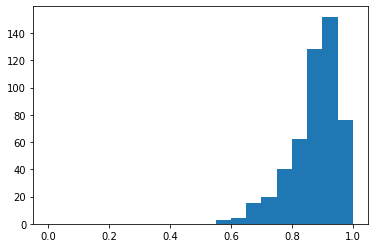




<START> how managed to avoid attention remains a mystery a potent mix of comedy <UNK> crime this one takes chances where tarantino plays it safe with <START> hollywood formula <START> risks don't always pay off one character in one sequence comes off inappropriately silly <UNK> falls flat in <START> lead role thomas jane gives a wonderful <UNK> complex performance <UNK> two brief appearances by mickey rourke hint at <START> high potential of this much under <UNK> mis used actor here's a director one should keep one's eye on
Expected: 1, Predicted mean: 0.598544, rmse: 0.431176, std: 0.157307


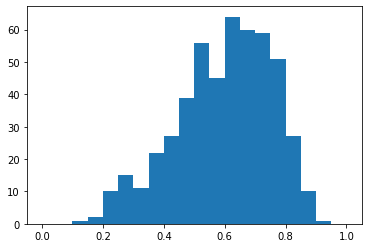




<START> eric ability to roll from character to character in this 'one man show' exhibits his true range as a character actor each persona has their own message to convey about truth society class drugs etc this is an absolute must have for anyone who is a serious fan of acting his performance contains some of <START> most hilarious <UNK> real moments i have ever experienced as a viewing audience
Expected: 1, Predicted mean: 0.741254, rmse: 0.276878, std: 0.098549


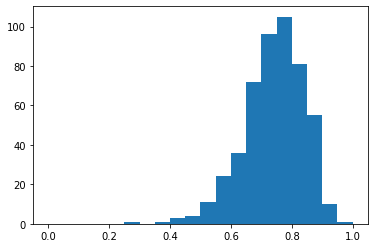




<START> welsh poet dylan thomas excused from serving in active duty is doing his bit for <START> war effort producing bits of prose for some propaganda branch of government in whitehall br br thomas is portrayed as a believing in free love married to a woman with an equally demanding artistic streak <UNK> likewise with a penchant for extramarital romance thomas writing <UNK> reciting his poetry in systematic domestic mayhem throughout becomes somewhat priggish towards <START> end resting somewhat uncomfortably on his society connections <UNK> pulling rank on a war veteran who had shot up his house <UNK> who was incidentally married to <START> woman he had been having an affair with br br <START> real story of this film is <START> love of two women one keira knightley whose first love was thomas matthew rhys <START> second sienna miller who is thomas's wife at times it reminds of <START> singing detective as in very good television with slightly sinister overtones laid on top of scen

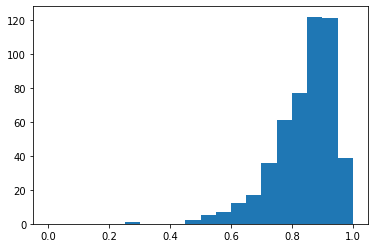

In [28]:
mean_y_train = np.mean(y_train)
std_y_train = np.std(y_train)

print("Training data predictions: mean of %s and std of %s\n" % (mean_y_train, std_y_train))

def calc_rmse(y1, y2):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y1, y2))))

def calc_log_likelihood(y, Yt_hat):
    return (tf.reduce_logsumexp(-0.5 * tau * (y - Yt_hat)**2., 0)
            - np.log(T) 
            - 0.5 * np.log(2 * np.pi) 
            - 0.5 * np.log(tau)) # paper states -0.5 as correct. Implementation states +0.5

def reduce_rmse(X_test, y_test, mc_samples=1):
    """
    MC dropout: Equivalent to performing T sochastic forward passes through the network and averaging the results. 
    """
    Y_samples = np.array([model.predict(X_test, batch_size=500, verbose=0) for _ in range(mc_samples)])
    mc_pred = np.mean(Y_samples * std_y_train + mean_y_train, 0)
    return (calc_rmse(y_test, mc_pred), Y_samples)


# predict(x_test_padded, y_test)
# (0.5039183, 0.49860904, -1.0451484)

def predict(X_test, y_test):
    """
        Function for making predictions with the Bayesian neural network.
        @param X_test   The tensor of features for the test data
        @param y_test   The tensor of labels for the test data
    """
        
    X_test = np.array(X_test, ndmin = 2)
    y_test = np.array(y_test, ndmin = 2, dtype="f").T

    # predictive mean and variance for the target variables of the test data
    rmse_standard_pred = reduce_rmse(X_test, y_test)[0]
    rmse, Y_samples = reduce_rmse(X_test, y_test, mc_samples=T)
    Yt_hat = Y_samples * std_y_train + mean_y_train

    log_likelihood = calc_log_likelihood(y_test, Yt_hat)
    mean_log_likelihood = np.mean(log_likelihood)

    return rmse_standard_pred, rmse, Y_samples, (mean_log_likelihood, log_likelihood)

test_size = 25
rmse_standard_pred, rmse, Y_samples, (mean_log_likelihood, log_likelihood) = predict(x_test_padded[:test_size], y_test[:test_size])
for i in range(test_size):
    samples = Y_samples[:, i]
    sentence = word_index.vec2sentence(x_test[i])
    expected = y_test[i]
    pred_mean = np.mean(samples, 0)
    rmse = calc_rmse(samples, expected)
    std = np.std(samples)
    
    print("%s\nExpected: %i, Predicted mean: %f, rmse: %f, std: %f" % (sentence, expected, pred_mean, rmse, std))
    plt.hist(samples, bins=20, range=(0,1))
    plt.show()
    print("\n\n")